In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
!pip install mlxtend imblearn xgboost
import zipfile
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from scipy.stats import pearsonr

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from imblearn.under_sampling import NearMiss

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from xgboost import XGBClassifier

In [2]:
import zipfile
import pandas as pd
import os

# Define the path to the zip file
zip_file_path = '/content/heart_disease_health_indicators_BRFSS2015.csv.zip'

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print(f"Error: zip file not found at {zip_file_path}")
else:
    # Create a directory to extract the contents
    extraction_path = '/content/extracted_data'
    os.makedirs(extraction_path, exist_ok=True)

    # Extract the contents of the zip file
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
            extracted_files = zip_ref.namelist()
        print(f"Successfully extracted {len(extracted_files)} files to {extraction_path}")

        # Find the CSV file (should be just one)
        csv_files = [f for f in extracted_files if f.lower().endswith('.csv')]

        if csv_files:
            # Load the first CSV file as 'data'
            csv_path = os.path.join(extraction_path, csv_files[0])
            data = pd.read_csv(csv_path)
            print(f"Successfully loaded data from: {csv_files[0]}")
            print(f"Shape of data: {data.shape}")
            print("\nFirst 5 rows of the data:")
            print(data.head())
        else:
            print("No CSV files found in the zip archive.")

    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"Error during extraction or loading: {e}")

Successfully extracted 1 files to /content/extracted_data
Successfully loaded data from: heart_disease_health_indicators_BRFSS2015.csv
Shape of data: (253680, 22)

First 5 rows of the data:
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0

In [3]:
data['HeartDisease_Binary'] = data['HeartDiseaseorAttack'].apply(lambda x: 1 if x >= 1 else 0)

In [4]:
data = data.drop(columns=['HeartDiseaseorAttack'])

In [5]:
data.sample()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,HeartDisease_Binary
205437,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,2.0,0.0,0.0,1.0,4.0,7.0,0


In [6]:
data_target = data["HeartDisease_Binary"]
data_features = data.drop(["Diabetes", "HeartDisease_Binary"], axis=1)

In [7]:
# columns_to_drop = ['Diabetes']
# data = data.drop(columns=columns_to_drop)

In [8]:
data_features.sample()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
252554,0.0,1.0,1.0,32.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,4.0,6.0,4.0


In [9]:
data_features.shape

(253680, 20)

In [10]:
column_names_list = data_features.columns.tolist()
column_names_list

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'Education',
 'Income']

In [11]:
data_target.value_counts()

,count
HeartDisease_Binary,
0,229787
1,23893


In [12]:
nm = NearMiss(version = 1 , n_neighbors = 10)

data_features, data_target = nm.fit_resample(data_features, data_target)

In [13]:
data.duplicated().sum()

np.int64(23899)

In [14]:
data.drop_duplicates(inplace = True)

In [15]:
threshold = 10
high_score_features_mic = []
feature_scores = mutual_info_classif(data_features, data_target, random_state=0)
for score, f_name in sorted(zip(feature_scores, data_features.columns), reverse=True)[:threshold]:
        high_score_features_mic.append(f_name)

print(high_score_features_mic)

['PhysHlth', 'GenHlth', 'Income', 'DiffWalk', 'MentHlth', 'Education', 'PhysActivity', 'BMI', 'Stroke', 'Veggies']


In [16]:
skb = SelectKBest(score_func=chi2, k=threshold)
sel_skb = skb.fit(data_features, data_target)
sel_skb_index = sel_skb.get_support()
df_norm_skb = data_features.iloc[:, sel_skb_index]
high_score_features_skb = list(df_norm_skb.columns)
print(high_score_features_skb)

In [17]:
pearson_list = []
for l in list(data_features.columns):
    p,_ = pearsonr(data_features[l], data_target)
    pearson_list.append(abs(p))

p_value=pd.Series(pearson_list,index=data_features.columns)
p_value.sort_values(ascending=False,inplace=True)
high_score_features_pearson = list(p_value.index[:threshold])

In [18]:
high_score_features = []
for h in  high_score_features_mic:
    if h in high_score_features_skb and h in high_score_features_pearson:
        high_score_features.append(h)

In [19]:
y = data_target

features_list = [
    ["all", data_features],

    ["mic 3", data_features[high_score_features_mic[:3]]],
    ["mic 5", data_features[high_score_features_mic[:5]]],
    ["mic 7", data_features[high_score_features_mic[:7]]],
    ["mic 10", data_features[high_score_features_mic]],

    ["skb 3", data_features[high_score_features_skb[:3]]],
    ["skb 5", data_features[high_score_features_skb[:5]]],
    ["skb 7", data_features[high_score_features_skb[:7]]],
    ["skb 10", data_features[high_score_features_skb]],

    ["pearson 3", data_features[high_score_features_pearson[:3]]],
    ["pearson 5", data_features[high_score_features_pearson[:5]]],
    ["pearson 7", data_features[high_score_features_pearson[:7]]],
    ["pearson 10", data_features[high_score_features_pearson]],

    ["best 7", data_features[high_score_features]],

    ["choose 3", data_features[['BMI','Age','HighBP']]],
    ["choose 5", data_features[['BMI','Age','HighBP','Smoker','MentHlth']]],
    ["choose 7", data_features[['BMI','Age','HighBP','Smoker','MentHlth', 'PhysHlth','GenHlth']]],
]

In [20]:
scalar = StandardScaler()
data = []

for name, X in features_list:
    data.append([name, scalar.fit_transform(X)])


In [21]:
splited_data = []
for name, X in data:
    X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.3)
    splited_data.append({
            'name': name ,'X_train': X_train,
            'X_test':X_test,'y_train':y_train,
            'y_test':y_test
        })

In [22]:
evaluations = pd.DataFrame()

In [23]:
data = splited_data[0]
pred_list = []
for data in tqdm(splited_data):
    fs = data["name"]
    models =[
         # ['LR', LogisticRegression(), data],
        ['RF', RandomForestClassifier(max_depth=5,n_estimators=1000, class_weight='balanced'), data],
        ['DT', DecisionTreeClassifier(max_depth=5), data],
        ['KNN', KNeighborsClassifier(n_neighbors= 6), data],
        # ['SVM', SVC(probability=True), data]
        ['XGB', XGBClassifier(max_depth=5, n_estimators=1000, use_label_encoder=False, eval_metric='logloss'), data]
    ]

    roc_list = []
    accuracy_list = []
    f1_list = []
    recall_list = []
    precision_list = []

    for name ,model, data in tqdm(models):
        X_train, X_test, y_train, y_test= data['X_train'], data['X_test'], data['y_train'], data['y_test']
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:,1]

        pred_list.append({
            "model": name,
            "fs": fs,
            "data": y_pred
        })

        roc_list.append(metrics.roc_auc_score(y_test,y_pred))

        y_pred = [0 if (y<0.5)else 1 for y in y_pred]

        accuracy_list.append(metrics.accuracy_score(y_test,y_pred))
        f1_list.append(metrics.f1_score(y_test,y_pred))
        recall_list.append(metrics.recall_score(y_test,y_pred))
        precision_list.append(metrics.precision_score(y_test,y_pred))

    names = [name for name ,_ ,_ in models]
    fsm = [data['name'] for _ ,_ ,data in models]
    evaluation = pd.DataFrame({'classifiers': names,'Feature selection method': fsm ,'AUC Score': roc_list, 'Accuracy':accuracy_list,'Precision':precision_list,'Recall':recall_list, 'F-measure':f1_list})

    evaluations = pd.concat([evaluations, evaluation], ignore_index=True)

    evaluation = evaluation.sort_values(by='AUC Score', ascending=False)
    print(evaluation)

 75%|███████▌  | 3/4 [00:09<00:02,  2.63s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

  6%|▌         | 1/17 [00:11<02:56, 11.02s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                      all   0.951118  0.900600   0.943610   
0          RF                      all   0.944557  0.882324   0.957016   
1          DT                      all   0.916716  0.859305   0.967583   
2         KNN                      all   0.910347  0.844866   0.883920   

     Recall  F-measure  
3  0.851650   0.895274  
0  0.800056   0.871525  
1  0.742869   0.840465  
2  0.793205   0.836109  



 75%|███████▌  | 3/4 [00:06<00:01,  1.70s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 12%|█▏        | 2/17 [00:18<02:18,  9.21s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    mic 3   0.910249  0.840960   0.922427   
0          RF                    mic 3   0.910100  0.840960   0.922427   
1          DT                    mic 3   0.908552  0.837333   0.947738   
2         KNN                    mic 3   0.878910  0.803013   0.820887   

     Recall  F-measure  
3  0.745161   0.824372  
0  0.745161   0.824372  
1  0.714664   0.814862  
2  0.776076   0.797853  



 75%|███████▌  | 3/4 [00:07<00:02,  2.05s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 18%|█▊        | 3/17 [00:27<02:02,  8.75s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    mic 5   0.925509  0.867606   0.946009   
0          RF                    mic 5   0.925011  0.867327   0.946273   
1          DT                    mic 5   0.913150  0.856515   0.964536   
2         KNN                    mic 5   0.897338  0.805594   0.783059   

     Recall  F-measure  
3  0.781657   0.856016  
0  0.780826   0.855625  
1  0.742311   0.838957  
2  0.849127   0.814756  



 75%|███████▌  | 3/4 [00:07<00:02,  2.15s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 24%|██▎       | 4/17 [00:35<01:52,  8.68s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    mic 7   0.938736  0.882185   0.942200   
0          RF                    mic 7   0.936074  0.878557   0.945540   
2         KNN                    mic 7   0.919163  0.818917   0.788410   
1          DT                    mic 7   0.917526  0.858189   0.898388   

     Recall  F-measure  
3  0.811025   0.871705  
0  0.800000   0.866702  
2  0.865300   0.825067  
1  0.803534   0.848318  



 75%|███████▌  | 3/4 [00:09<00:02,  2.71s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 29%|██▉       | 5/17 [00:46<01:52,  9.39s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                   mic 10   0.942947  0.888463   0.947445   
0          RF                   mic 10   0.937949  0.875907   0.950966   
2         KNN                   mic 10   0.920276  0.866629   0.895023   
1          DT                   mic 10   0.913407  0.853516   0.897888   

     Recall  F-measure  
3  0.821958   0.880252  
0  0.792028   0.864250  
2  0.829930   0.861248  
1  0.796923   0.844398  



 75%|███████▌  | 3/4 [00:06<00:01,  1.73s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 35%|███▌      | 6/17 [00:53<01:36,  8.78s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    skb 3   0.795010  0.753627   0.869494   
0          RF                    skb 3   0.791723  0.753627   0.869494   
1          DT                    skb 3   0.785233  0.753627   0.869494   
2         KNN                    skb 3   0.758815  0.694336   0.687056   

     Recall  F-measure  
3  0.593092   0.705175  
0  0.593092   0.705175  
1  0.593092   0.705175  
2  0.706543   0.696663  



 75%|███████▌  | 3/4 [00:07<00:02,  2.03s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 41%|████      | 7/17 [01:02<01:25,  8.56s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    skb 5   0.888816  0.815499   0.892337   
0          RF                    skb 5   0.883835  0.810896   0.896746   
1          DT                    skb 5   0.865700  0.801060   0.903732   
2         KNN                    skb 5   0.863131  0.798200   0.812473   

     Recall  F-measure  
3  0.720714   0.797396  
0  0.705899   0.789959  
1  0.677236   0.774260  
2  0.779286   0.795533  



 75%|███████▌  | 3/4 [00:08<00:02,  2.32s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 47%|████▋     | 8/17 [01:11<01:18,  8.72s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    skb 7   0.924744  0.871791   0.935633   
0          RF                    skb 7   0.921441  0.865653   0.942691   
1          DT                    skb 7   0.906118  0.856515   0.926644   
2         KNN                    skb 7   0.897442  0.862932   0.907982   

     Recall  F-measure  
3  0.796543   0.860504  
0  0.776591   0.851618  
1  0.772095   0.842339  
2  0.805536   0.853697  



 75%|███████▌  | 3/4 [00:10<00:02,  2.82s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 53%|█████▎    | 9/17 [01:22<01:15,  9.39s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                   skb 10   0.942480  0.886091   0.949554   
0          RF                   skb 10   0.939812  0.876046   0.961374   
2         KNN                   skb 10   0.913934  0.868164   0.902528   
1          DT                   skb 10   0.900693  0.857910   0.934992   

     Recall  F-measure  
3  0.815775   0.877595  
0  0.783863   0.863591  
2  0.825808   0.862465  
1  0.769649   0.844302  



 75%|███████▌  | 3/4 [00:06<00:01,  1.68s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 59%|█████▉    | 10/17 [01:28<01:00,  8.64s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                pearson 3   0.894302  0.817243   0.872834   
0          RF                pearson 3   0.894067  0.817243   0.872834   
1          DT                pearson 3   0.889212  0.815360   0.873005   
2         KNN                pearson 3   0.862973  0.779576   0.759551   

     Recall  F-measure  
3  0.743525   0.803008  
0  0.743525   0.803008  
1  0.738931   0.800392  
2  0.819410   0.788346  



 75%|███████▌  | 3/4 [00:07<00:02,  2.00s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 65%|██████▍   | 11/17 [01:37<00:51,  8.51s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                pearson 5   0.922210  0.855329   0.933116   
0          RF                pearson 5   0.920148  0.851632   0.929529   
1          DT                pearson 5   0.905343  0.842425   0.888162   
2         KNN                pearson 5   0.896765  0.835310   0.854043   

     Recall  F-measure  
3  0.763649   0.839920  
0  0.759018   0.835664  
1  0.781333   0.831330  
2  0.806456   0.829568  



 75%|███████▌  | 3/4 [00:07<00:02,  2.08s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 71%|███████   | 12/17 [01:45<00:42,  8.45s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                pearson 7   0.935189  0.876256   0.944142   
0          RF                pearson 7   0.933538  0.868862   0.951478   
2         KNN                pearson 7   0.913786  0.839704   0.837471   
1          DT                pearson 7   0.898694  0.853864   0.929225   

     Recall  F-measure  
3  0.799721   0.865951  
0  0.777251   0.855585  
2  0.842847   0.840150  
1  0.765946   0.839722  



 75%|███████▌  | 3/4 [00:09<00:02,  2.69s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 76%|███████▋  | 13/17 [01:55<00:36,  9.06s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB               pearson 10   0.945790  0.891950   0.948284   
0          RF               pearson 10   0.939976  0.875558   0.948956   
2         KNN               pearson 10   0.918768  0.870675   0.900183   
1          DT               pearson 10   0.917858  0.856724   0.966962   

     Recall  F-measure  
3  0.827383   0.883717  
0  0.791819   0.863295  
2  0.831600   0.864533  
1  0.736435   0.836100  



 75%|███████▌  | 3/4 [00:09<00:02,  2.65s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 82%|████████▏ | 14/17 [02:06<00:28,  9.48s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                   best 7   0.941707  0.887277   0.945781   
0          RF                   best 7   0.938122  0.877581   0.957473   
2         KNN                   best 7   0.922369  0.861537   0.879651   
1          DT                   best 7   0.915410  0.856934   0.897555   

     Recall  F-measure  
3  0.816823   0.876585  
0  0.785084   0.862751  
2  0.831198   0.854738  
1  0.799317   0.845592  



 75%|███████▌  | 3/4 [00:06<00:01,  1.76s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 88%|████████▊ | 15/17 [02:14<00:18,  9.11s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                 choose 3   0.775670  0.695033   0.716214   
0          RF                 choose 3   0.770431  0.690081   0.713391   
1          DT                 choose 3   0.753087  0.681641   0.744791   
2         KNN                 choose 3   0.724421  0.649902   0.629206   

     Recall  F-measure  
3  0.626369   0.668285  
0  0.615275   0.660710  
1  0.533779   0.621872  
2  0.696771   0.661267  



 75%|███████▌  | 3/4 [00:07<00:02,  2.10s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 94%|█████████▍| 16/17 [02:23<00:08,  8.97s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                 choose 5   0.858843  0.767787   0.840697   
0          RF                 choose 5   0.850975  0.757743   0.849247   
1          DT                 choose 5   0.834704  0.745954   0.892803   
2         KNN                 choose 5   0.821676  0.732840   0.735483   

     Recall  F-measure  
3  0.669369   0.745314  
0  0.635564   0.727030  
1  0.567679   0.694052  
2  0.739728   0.737599  



 75%|███████▌  | 3/4 [00:08<00:02,  2.22s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

100%|██████████| 17/17 [02:32<00:00,  8.96s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                 choose 7   0.925294  0.858468   0.944927   
0          RF                 choose 7   0.921305  0.848354   0.959218   
1          DT                 choose 7   0.904232  0.845285   0.957522   
2         KNN                 choose 7   0.892976  0.819685   0.834947   

     Recall  F-measure  
3  0.760593   0.842798  
0  0.726891   0.827049  
1  0.721857   0.823154  
2  0.795833   0.814921  


In [27]:
# evaluations = evaluations.sort_values(by='AUC Score', ascending=False, ignore_index=True)
# pd.set_option("display.max_rows", None)
# evaluations

X = data_features[high_score_features_mic]  # no .values here
columns_list = X.columns.tolist()

In [28]:
high_score_features_mic
classifier = XGBClassifier(
    max_depth=5,
    n_estimators=1000,
    use_label_encoder=False,
    eval_metric='logloss'
)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(range(len(columns_list)))),
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [29]:
X = data_features[columns_list]
y = data_target
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.7)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                   9])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [30]:
print(np.mean(y_train))  # How many % are '1's
print(np.mean(y_test))

0.49459365190094173
0.5023168216196825


In [31]:
y_pred = model.predict_proba(X_test)[:,1]
score = metrics.roc_auc_score(y_test,y_pred)
score

np.float64(0.9378169216367538)

First 20 raw predicted probabilities:
[1.         0.96604794 0.06494569 0.70820135 0.54375386 0.99913675
 1.         1.         0.12369881 0.87243515 0.06494569 0.96662104
 0.11534355 0.02831459 0.06320029 0.07353733 0.05591854 0.04561055
 1.         0.9998841 ]
----------------------------------------------------------------------
Train


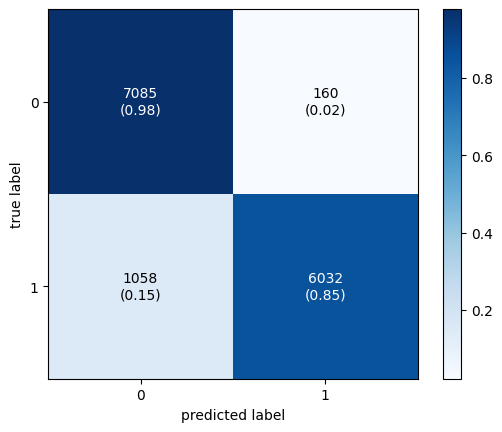

Test


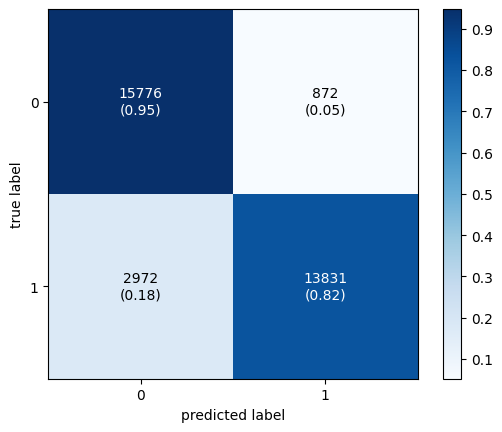

----------------------------------------------------------------------


In [32]:
# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:,1]
print("First 20 raw predicted probabilities:")
print(y_pred_proba[:20])  # <<<<< important

y_pred = [0 if (y<0.5)else 1 for y in y_pred]

print("----------------------------------------------------------------------")

print("Train")

y_pred_trean = model.predict_proba(X_train)[:,1]
y_pred_trean = [0 if (y<0.5)else 1 for y in y_pred_trean]

cm1 = confusion_matrix(y_train, y_pred_trean)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                        show_normed=True,
                        colorbar=True)
plt.show()

print("Test")
cm1 = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                        show_normed=True,
                        colorbar=True)
plt.show()

print("----------------------------------------------------------------------")

In [33]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_train, y_train, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

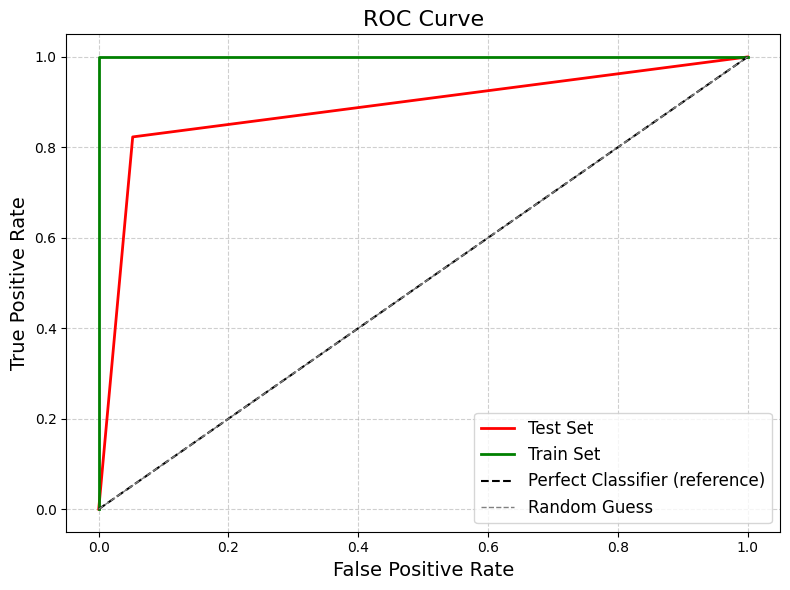

In [34]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='r', label='Test')
plt.plot(fpr2, tpr2, linestyle='--',color='g', label='Trean')
plt.plot(p_fpr, p_tpr, linestyle='--', color='k')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [35]:
from joblib import dump, load

dump(model, 'xgboost_heart_model_pipeline.joblib')

['xgboost_heart_model_pipeline.joblib']

In [36]:
loaded_model = load('xgboost_heart_model_pipeline.joblib')

In [37]:
y_pred = loaded_model.predict_proba(X_test)[37,:]
y_pred.argmax()

np.int64(1)

In [38]:
# Load the model
from joblib import load
loaded_model = load('/content/xgboost_heart_model_pipeline.joblib')

# If your model is a pipeline, you can check the column transformer
# This assumes the first step in your pipeline is a ColumnTransformer
if hasattr(loaded_model, 'steps'):
    # Try to find a ColumnTransformer in the pipeline
    for step_name, step_transformer in loaded_model.steps:
        if hasattr(step_transformer, 'transformers_'):
            print(f"Found transformer: {step_name}")
            # Print the feature names if available
            if hasattr(step_transformer, 'feature_names_in_'):
                print(f"Expected features: {step_transformer.feature_names_in_}")
                print(f"Number of features expected: {len(step_transformer.feature_names_in_)}")

            # Look at individual transformers in the ColumnTransformer
            for name, transformer, columns in step_transformer.transformers_:
                print(f"Transformer: {name}, Columns: {columns}")

Found transformer: preprocessor
Expected features: ['PhysHlth' 'GenHlth' 'Income' 'DiffWalk' 'MentHlth' 'Education'
 'PhysActivity' 'BMI' 'Stroke' 'Veggies']
Number of features expected: 10
Transformer: num, Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [39]:
columns_index = data_features.columns

columns_list = columns_index.tolist()

columns_list

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'Education',
 'Income']

In [40]:
import numpy as np
from sklearn import metrics
from joblib import load

# Load the model
model_path = '/content/xgboost_heart_model_pipeline.joblib'
try:
    loaded_model = load(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

def predict_diabetes():
    try:
        # Get feature input from the user
        HighBP = int(input("Enter HighBP (0 or 1): "))
        HighChol = int(input("Enter HighChol (0 or 1): "))
        CholCheck = int(input("Enter CholCheck (0 or 1): "))
        BMI = int(input("Enter BMI: "))
        Smoker = int(input("Enter Smoker (0 or 1): "))
        Stroke = int(input("Enter Stroke (0 or 1): "))
        PhysActivity = int(input("Enter PhysActivity (0 or 1): "))
        Fruits = int(input("Enter Fruits (0 or 1): "))
        Veggies = int(input("Enter Veggies (0 or 1): "))
        HvyAlcoholConsump = int(input("Enter HvyAlcoholConsump (0 or 1): "))
        AnyHealthcare = int(input("Enter AnyHealthcare (0 or 1): "))
        NoDocbcCost = int(input("Enter NoDocbcCost (0 or 1): "))
        GenHlth = int(input("Enter GenHlth (1-5): "))
        MentHlth = int(input("Enter MentHlth (0-30): "))
        PhysHlth = int(input("Enter PhysHlth (0-30): "))
        DiffWalk = int(input("Enter DiffWalk (0 or 1): "))
        Sex = int(input("Enter Sex (0 for Female, 1 for Male): "))
        Age = int(input("Enter Age (1-14): "))
        Education = int(input("Enter Education (1-6): "))
        Income = int(input("Enter Income (1-8): "))

        features = [HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,
                    PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare,
                    NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age,
                    Education, Income]

        features_array = np.array(features).reshape(1, -1)

        # Make prediction
        try:
            prob = loaded_model.predict_proba(features_array)[:,1][0]
            prediction = 1 if prob >= 0.5 else 0
            return f"Prediction: {'Heart Disease' if prediction == 1 else 'No Heart Disease'} (Probability: {prob:.2f})"
        except Exception as e:
            print(f"Error during prediction: {e}")
            prediction = loaded_model.predict(features_array)[0]
            return f"Prediction: {'Heart Disease' if prediction == 1 else 'No Heart Disease'}"

    except Exception as e:
        return f"Error during prediction: {e}"

# Evaluate model (optional)
try:
    y_pred = loaded_model.predict_proba(X_test)[:,1]
    score = metrics.roc_auc_score(y_test, y_pred)
    print(f"Model ROC-AUC score: {score:.4f}")
except Exception as e:
    print(f"Skipping model evaluation: {e}")

# Example usage
prediction_result = predict_diabetes()
print(prediction_result)

Model loaded successfully!
Model ROC-AUC score: 0.9378
Enter HighBP (0 or 1): 1
Enter HighChol (0 or 1): 1
Enter CholCheck (0 or 1): 1
Enter BMI: 1
Enter Smoker (0 or 1): 1
Enter Stroke (0 or 1): 1
Enter PhysActivity (0 or 1): 1
Enter Fruits (0 or 1): 1
Enter Veggies (0 or 1): 1
Enter HvyAlcoholConsump (0 or 1): 1
Enter AnyHealthcare (0 or 1): 1
Enter NoDocbcCost (0 or 1): 1
Enter GenHlth (1-5): 1
Enter MentHlth (0-30): 1
Enter PhysHlth (0-30): 1
Enter DiffWalk (0 or 1): 1
Enter Sex (0 for Female, 1 for Male): 1
Enter Age (1-14): 1
Enter Education (1-6): 1
Enter Income (1-8): 1
Error during prediction: X has 20 features, but ColumnTransformer is expecting 10 features as input.
Error during prediction: X has 20 features, but ColumnTransformer is expecting 10 features as input.


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gradio as gr
import joblib

# Load the trained model
loaded_model = joblib.load('/content/xgboost_heart_model_pipeline.joblib')
print("Model loaded successfully!")

# Define prediction function
def predict_diabetes(HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,
                    PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare,
                    NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age,
                    Education, Income):
    # Create a list of features (without HeartDiseaseorAttack)
    features = [HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,
                PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare,
                NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age,
                Education, Income]

    # Convert features to a NumPy array and reshape
    features_array = np.array(features).reshape(1, -1)

    # Make prediction with error handling
    try:
        prob = loaded_model.predict_proba(features_array)[:,1][0]
        prediction = 1 if prob >= 0.5 else 0
        result = f"{'Heart Disease' if prediction == 1 else 'No Heart Disease'} (Probability: {prob:.2f})"
    except Exception as e:
        print(f"Error during prediction: {e}")
        raise e

    return result

# Build Gradio Interface
with gr.Blocks(title="Heart Disease Risk Prediction Tool") as demo:
    gr.Markdown("# Heart Disease Risk Prediction Tool")
    gr.Markdown("Enter your health information below to assess your Heart Disease risk.")

    with gr.Row():
        with gr.Column():
            HighBP = gr.Radio([0, 1], label="High Blood Pressure (0=No, 1=Yes)",
                              info="Have you been told you have high blood pressure?", value=0)
            HighChol = gr.Radio([0, 1], label="High Cholesterol (0=No, 1=Yes)",
                                info="Have you been told you have high cholesterol?", value=0)
            CholCheck = gr.Radio([0, 1], label="Cholesterol Check (0=No, 1=Yes)",
                                 info="Had cholesterol check in past 5 years?", value=1)
            BMI = gr.Slider(10, 60, value=25, label="BMI", info="Body Mass Index")
            Smoker = gr.Radio([0, 1], label="Smoker (0=No, 1=Yes)",
                             info="Smoked at least 100 cigarettes in lifetime?", value=0)
            Stroke = gr.Radio([0, 1], label="History of Stroke (0=No, 1=Yes)",
                              info="Have you ever had a stroke?", value=0)

        with gr.Column():
            PhysActivity = gr.Radio([0, 1], label="Physical Activity (0=No, 1=Yes)",
                                   info="Exercise in past 30 days (other than regular job)?", value=1)
            Fruits = gr.Radio([0, 1], label="Fruit Consumption (0=No, 1=Yes)",
                             info="Eat fruit at least once per day?", value=1)
            Veggies = gr.Radio([0, 1], label="Vegetable Consumption (0=No, 1=Yes)",
                              info="Eat vegetables at least once per day?", value=1)
            HvyAlcoholConsump = gr.Radio([0, 1], label="Heavy Alcohol Consumption (0=No, 1=Yes)",
                                        info="Men: >14 drinks/week, Women: >7 drinks/week", value=0)
            AnyHealthcare = gr.Radio([0, 1], label="Healthcare Coverage (0=No, 1=Yes)",
                                    info="Do you have any kind of health insurance?", value=1)
            NoDocbcCost = gr.Radio([0, 1], label="Doctor Cost Barrier (0=No, 1=Yes)",
                                  info="Couldn't see doctor due to cost in past year?", value=0)
            GenHlth = gr.Slider(1, 5, step=1, value=3, label="General Health (1=Excellent, 5=Poor)",
                               info="Rate your general health")

    with gr.Row():
        with gr.Column():
            MentHlth = gr.Slider(0, 30, step=1, value=0, label="Mental Health (0-30 days)",
                                info="Days of poor mental health in past month")
            PhysHlth = gr.Slider(0, 30, step=1, value=0, label="Physical Health (0-30 days)",
                                info="Days of poor physical health in past month")
            DiffWalk = gr.Radio([0, 1], label="Difficulty Walking (0=No, 1=Yes)",
                               info="Serious difficulty walking or climbing stairs?", value=0)
            Sex = gr.Radio([0, 1], label="Sex (0=Female, 1=Male)", value=0)

        with gr.Column():
            Age = gr.Slider(1, 14, step=1, value=7, label="Age Category (1-14)",
                           info="1=18-24, 2=25-29, ..., 13=80+")
            Education = gr.Slider(1, 6, step=1, value=4, label="Education Level (1-6)",
                                 info="1=No school to 6=College graduate")
            Income = gr.Slider(1, 8, step=1, value=5, label="Income Level (1-8)",
                              info="1=<$10K to 8=>$75K")

    with gr.Row():
        predict_btn = gr.Button("Predict Heart Disease Risk", variant="primary")

    output = gr.Textbox(label="Prediction Result")

    predict_btn.click(
        fn=predict_diabetes,
        inputs=[HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,
                PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare,
                NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age,
                Education, Income],
        outputs=output
    )

    gr.Markdown("### Understanding the Results")
    gr.Markdown("- **Heart Disease**: You may have or be at risk of Heart Disease based on your health inputs.")
    gr.Markdown("- **No Heart Disease**: You likely do not have Heart Disease based on your inputs.")
    gr.Markdown("- **Probability**: The model's confidence level in its prediction.")
    gr.Markdown("*Note: This is an educational tool, not medical advice.*")

# Launch the Gradio app
demo.launch()

Model loaded successfully!
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://158c2011e355266040.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
